# MARCH MADNESS MACHINE

This notebook is an attempt to predict March Madness brackets through the methods of machine learning. The tournament starts in less than two weeks from the start of this project, so one goal is to keep it simple. There is limited time for in-depth analysis and exploration. It is through this experiment I hope to be able to use very limited information to build a simplified model that still produces results. It seems that very often March Madness models are created that try to examine every excruciating detail and statistic to perfectly predict the outcomes. This is impossible. There are too many unknowns in the world of sports, especially March Madness, to create a model with perfect prediction. Most of the time, this leads to overfitting. Instead, I aim to experiment on the ability of a simple model to perform in a complicated world. Instead of looking for every possible detail, to create a quick and simple model to perform better than the average, educated NCAA basketball fan.

Once a prediction method is created, it will be tested against other "testing" brackets. I will create two brackets will little knowledge about NCAA basketball. The two brakets will mainly consist of picking based on seeds, while accounting for some upsets. These will be the "guess" brackets. Next, I will create two more brackets after carefully examining expert opinions and rankings. These will be the "educated guess" brackets. Finally I will pick the two best models from the experiment and create two brackets from the results accordingly. I will them examine which brackets perform the best, seeing if the randomness of march madness can create chaos within the experiment. The results remain to be seen.

In [1]:
#All necessary imports
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# STEP 1: EXPLORING THE DATA

For starters, I plan on using data from the Kaggle March Madness competition. Most of the data is presented in a very clean format and will eliminate the need for data scraping and excess data cleaning to save time. However, many other datasets exist that could provide useful information and I plan to be more prepared in future years with more time to explore this data. For now, the Kaggle data will be the main source.

The first dataset of interest is the regular season detailed results data, which contains regular season statistics all the way back to 2003. 

In [2]:
season_stats = pd.read_csv("MRegularSeasonDetailedResults.csv")
season_stats.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


Some of these columns could use some explanation. They are broken into the winning team (W) and losing team(L) stats. For the winning team, the stats would be as follows:


WFGM - field goals made (by the winning team)

WFGA - field goals attempted (by the winning team)

WFGM3 - three pointers made (by the winning team)

WFGA3 - three pointers attempted (by the winning team)

WFTM - free throws made (by the winning team)

WFTA - free throws attempted (by the winning team)

WOR - offensive rebounds (pulled by the winning team)

WDR - defensive rebounds (pulled by the winning team)

WAst - assists (by the winning team)

WTO - turnovers committed (by the winning team)

WStl - steals (accomplished by the winning team)

WBlk - blocks (accomplished by the winning team)

WPF - personal fouls committed (by the winning team)


The stats for the losing team would be the same except the W at the start would be replaced by an L.

Using this dataframe alone, there is plenty of information to build a simple model. 

In [3]:
team_names = pd.read_csv("MTeams.csv")
team_names.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2022
1,1102,Air Force,1985,2022
2,1103,Akron,1985,2022
3,1104,Alabama,1985,2022
4,1105,Alabama A&M,2000,2022


The above dataframe contains all the teams names and team IDs that will be useful in identifying teams in future processes.

In [4]:
rankings = pd.read_csv("MMasseyOrdinals.csv")
rankings.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
4521715,2022,100,WOL,1468,183
4521716,2022,100,WOL,1469,259
4521717,2022,100,WOL,1470,209
4521718,2022,100,WOL,1471,270
4521719,2022,100,WOL,1472,296


The above dataframe contains information of the team rankings based on different days and systems. I do not think earlier rankings will be as important and instead the rankings right before the start of the NCAA tournament to be the most important. These occur on `RankingDayNum` 133

In [5]:
final_rankings = rankings[rankings['RankingDayNum'] == 133]
final_rankings.head()
print(final_rankings['SystemName'].value_counts())
print("All rating systems: ", final_rankings['SystemName'].unique())

MOR    6180
SAG    6180
WLK    6177
POM    6177
DOL    6176
       ... 
REI     326
RM      326
PH      326
D1A     200
TRX     120
Name: SystemName, Length: 172, dtype: int64
All rating systems:  ['AP' 'ARG' 'BIH' 'BOB' 'BRZ' 'COL' 'DOL' 'DUN' 'DWH' 'ECK' 'ENT' 'ERD'
 'GRN' 'GRS' 'HER' 'HOL' 'IMS' 'MAS' 'MKV' 'MOR' 'POM' 'RPI' 'RTH' 'SAG'
 'SAU' 'SE' 'SEL' 'STR' 'TSR' 'USA' 'WLK' 'WOB' 'WOL' 'WTE' 'BD' 'CNG'
 'DES' 'JON' 'LYN' 'MGY' 'NOR' 'REI' 'RM' 'SIM' 'ACU' 'BCM' 'CMV' 'DC'
 'KLK' 'REN' 'RIS' 'ROH' 'SAP' 'SCR' 'WIL' 'DOK' 'JCI' 'KPK' 'MB' 'PH'
 'PIG' 'PKL' 'TRX' 'CPR' 'ISR' 'KRA' 'LYD' 'RTR' 'UCS' 'BKM' 'CPA' 'JEN'
 'PGH' 'REW' 'RSE' 'SPW' 'STH' 'BPI' 'DC2' 'DCI' 'HKB' 'LMC' 'NOL' 'OMY'
 'RTB' 'KEL' 'KMV' 'RT' 'TW' 'AUS' 'KOS' 'PEQ' 'PTS' 'ROG' 'RTP' 'TMR'
 '7OT' 'ADE' 'BBT' 'BNM' 'BUR' 'CJB' 'CRO' 'EBP' 'HAT' 'MSX' 'SFX' 'TBD'
 'BLS' 'D1A' 'DII' 'KBM' 'TPR' 'MvG' 'PPR' 'SP' 'SPR' 'STF' 'STS' 'TRP'
 'UPS' 'WMR' 'BWE' 'LOG' 'TRK' 'DAV' 'FAS' 'FSH' 'HAS' 'HRN' 'KPI' 'MCL'
 'CRW' 'DD

Looks like there are a bunch of different rating systems out there. The Pomeroy (POM) rating is one of the most popular and considered one of the best. I plan to use this as an extra feature. 

In [6]:
pom = final_rankings[final_rankings['SystemName'] == 'POM']
print(pom.head())

#I decided to prepare some other ratings systems as well and, time-permitting, may add them to the model
mor = final_rankings[final_rankings['SystemName'] == 'MOR']
sag = final_rankings[final_rankings['SystemName'] == 'SAG']
wlk = final_rankings[final_rankings['SystemName'] == 'WLK']
dol = final_rankings[final_rankings['SystemName'] == 'DOL']

        Season  RankingDayNum SystemName  TeamID  OrdinalRank
127259    2003            133        POM    1102          160
127260    2003            133        POM    1103          163
127261    2003            133        POM    1104           33
127262    2003            133        POM    1105          307
127263    2003            133        POM    1106          263


# STEP 2: FEATURE SELECTION

Now that our preliminary data is selected, it is now time to decide what features we want our model to contain. 

The list of features incude:

Number of wins

Average points scored

Average points against

POM, MOR, SAG, WLK, and DOL rankings

Average steals

Average rebounds

Average turnovers

I decided to use more than just the Ken Pom rankings and to utilize the MOR, SAG, WALK, and DOL rankings. This will provide more variability than the "most popular" POM rankings that are commonly referred when making brackets

Now to clean up that `season_stats` dataframe to only the stats we are going to use...

In [19]:
season_stat = season_stats[["Season", "WTeamID", "LTeamID", "WScore", "LScore", "WStl", "LStl", "WOR", "WDR", "LOR", "LDR", "WTO", "LTO", "WAst", "LAst", "WBlk", "LBlk", "WPF", "LPF", "WFGA", "LFGA", "WFGA3", "LFGA3", "WFGM", "LFGM", "WFGM3", "LFGM3"]]
print(season_stat.tail())

#need season stats without 2022 season, since rankings have not reached day 133 yet. This will be used until day 133 results arrive
no2022_season_stat = season_stat[season_stat['Season'] != 2022]
print(no2022_season_stat.head())

        Season  WTeamID  LTeamID  WScore  LScore  WStl  LStl  WOR  WDR  LOR  \
100418    2022     1400     1242      79      76     7     3   14   18    5   
100419    2022     1411     1126      66      63    10    13   12   27    5   
100420    2022     1422     1441      68      49    11     8   11   22   10   
100421    2022     1438     1181      69      68    10     3   10   20   11   
100422    2022     1439     1338      74      47     6     3    9   26    0   

        ...  WPF  LPF  WFGA  LFGA  WFGA3  LFGA3  WFGM  LFGM  WFGM3  LFGM3  
100418  ...   21   21    67    48     20     13    28    28      3      5  
100419  ...   19   23    59    49     20     21    24    20      2      8  
100420  ...   13   12    56    53     32     24    23    18     13      5  
100421  ...   17   11    65    52     12     17    31    22      2      6  
100422  ...   12   14    55    40     27     20    29    15     13     10  

[5 rows x 27 columns]
   Season  WTeamID  LTeamID  WScore  LScore  W

In [20]:
#function to get team name from ID and vice versa
def getTeamName(teamID):
    name = team_names[team_names['TeamID'] == teamID]
    return name.iloc[0][1]

def getTeamID(teamName):
    teamID = team_names[team_names['TeamName'] == teamName]
    return teamID.iloc[0][0]

#verifying they work
print(getTeamName(1234))
print(getTeamID('Iowa'))

Iowa
1234


In [21]:
#Get functions for all stat features and testing on Gonzaga 2019
def getNumWins(teamID, year):
    all_wins = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    wins = all_wins.shape[0]
    return wins

print("Gonzaga Wins 2019: ", getNumWins(1211, 2019))

def getPointsScored(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    points = (win_games["WScore"].sum() + lose_games["LScore"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return points

print("Gonzaga Average Points Scored 2019: ", getPointsScored(1211, 2019))

def getPointsAgainst(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    points = (win_games["LScore"].sum() + lose_games["WScore"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return points

print("Gonzaga Average Points Against 2019: ", getPointsAgainst(1211, 2019))

def getSteals(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    steals = (win_games["WStl"].sum() + lose_games["LStl"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return steals

print("Gonzaga Average Steals 2019: ", getSteals(1211, 2019))

def getRebounds(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    rebounds = (win_games["WOR"].sum() + win_games["WDR"].sum() + lose_games["LOR"].sum() + lose_games["LDR"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return rebounds

print("Gonzaga Average Rebounds 2019: ", getRebounds(1211, 2019))

def getTurnovers(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    turnovers = (win_games["WTO"].sum() + lose_games["LTO"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return turnovers

def getAssists(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    assists = (win_games["WAst"].sum() + lose_games["WAst"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return assists

def getBlocks(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    blocks = (win_games["WBlk"].sum() + lose_games["LBlk"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return blocks

def getFouls(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    fouls = (win_games["WPF"].sum() + lose_games["LPF"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return fouls

def getFieldGoalsAttempt(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    field_goals_attempt = (win_games["WFGA"].sum() + lose_games["LFGA"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return field_goals_attempt

def getThreeAttempt(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    threes = (win_games["WFGA3"].sum() + lose_games["LFGA3"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return threes

def getFieldGoalsMade(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    field_goals = (win_games["WFGM"].sum() + lose_games["LFGM"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return field_goals

def getThreeMade(teamID, year):
    win_games = season_stat[(season_stat["WTeamID"] == teamID) & (season_stat["Season"] == year)]
    lose_games = season_stat[(season_stat["LTeamID"] == teamID) & (season_stat["Season"] == year)]
    threes = (win_games["WFGM3"].sum() + lose_games["LFGM3"].sum()) / (win_games.shape[0] + lose_games.shape[0])
    return threes

print("Gonzaga Average Turnovers 2019: ", getTurnovers(1211, 2019))
print("Gonzaga Average Assists 2019: ", getAssists(1211, 2019))
print("Gonzaga Average Blocks 2019: ", getBlocks(1211, 2019))
print("Gonzaga Average Fouls 2019: ", getFouls(1211, 2019))
print("Gonzaga Average Field Goal Attempts 2019: ", getFieldGoalsAttempt(1211, 2019))
print("Gonzaga Average Three Pointer Attempts 2019: ", getThreeAttempt(1211, 2019))
print("Gonzaga Average Field Goals Made 2019: ", getFieldGoalsMade(1211, 2019))
print("Gonzaga Average Three Pointers Made 2019: ", getThreeMade(1211, 2019))

Gonzaga Wins 2019:  30
Gonzaga Average Points Scored 2019:  88.84848484848484
Gonzaga Average Points Against 2019:  65.06060606060606
Gonzaga Average Steals 2019:  7.545454545454546
Gonzaga Average Rebounds 2019:  38.63636363636363
Gonzaga Average Turnovers 2019:  10.363636363636363
Gonzaga Average Assists 2019:  18.424242424242426
Gonzaga Average Blocks 2019:  5.484848484848484
Gonzaga Average Fouls 2019:  16.060606060606062
Gonzaga Average Field Goal Attempts 2019:  60.515151515151516
Gonzaga Average Three Pointer Attempts 2019:  21.333333333333332
Gonzaga Average Field Goals Made 2019:  32.18181818181818
Gonzaga Average Three Pointers Made 2019:  7.787878787878788


In [22]:
#Get functions for the POM and more ratings
def getPOM(teamID, year):
    rank_line = pom[(pom["TeamID"] == teamID) & (pom["Season"] == year)]
    rank = rank_line.iloc[0][4]
    return rank

print("Gonzaga POM ranking 2019: ", getPOM(1211, 2019))

def getMOR(teamID, year):
    rank_line = mor[(mor["TeamID"] == teamID) & (mor["Season"] == year)]
    rank = rank_line.iloc[0][4]
    return rank

print("Gonzaga MOR ranking 2019: ", getMOR(1211, 2019))

def getSAG(teamID, year):
    rank_line = sag[(sag["TeamID"] == teamID) & (sag["Season"] == year)]
    rank = rank_line.iloc[0][4]
    return rank

print("Gonzaga SAG ranking 2019: ", getSAG(1211, 2019))

def getWLK(teamID, year):
    rank_line = wlk[(wlk["TeamID"] == teamID) & (wlk["Season"] == year)]
    rank = rank_line.iloc[0][4]
    return rank

print("Gonzaga WLK ranking 2019: ", getWLK(1211, 2019))

def getDOL(teamID, year):
    rank_line = dol[(dol["TeamID"] == teamID) & (dol["Season"] == year)]
    rank = rank_line.iloc[0][4]
    return rank

print("Gonzaga DOL ranking 2019: ", getDOL(1211, 2019))


Gonzaga POM ranking 2019:  2
Gonzaga MOR ranking 2019:  2
Gonzaga SAG ranking 2019:  5
Gonzaga WLK ranking 2019:  5
Gonzaga DOL ranking 2019:  7


In [24]:
#create team vectors
def getTeamVector(teamID, year):
    wins = getNumWins(teamID, year)
    points_scored = getPointsScored(teamID, year)
    points_against = getPointsAgainst(teamID, year)
    steals = getSteals(teamID, year)
    rebounds = getRebounds(teamID, year)
    turnovers = getTurnovers(teamID, year)
    assists = getAssists(teamID, year)
    blocks = getBlocks(teamID, year)
    fouls = getFouls(teamID, year)
    fga = getFieldGoalsAttempt(teamID, year)
    fga3 = getThreeAttempt(teamID, year)
    fgm = getFieldGoalsMade(teamID, year)
    fgm3 = getThreeMade(teamID, year)
    pom = getPOM(teamID, year)
    mor = getMOR(teamID, year)
    sag = getSAG(teamID, year)
    wlk = getWLK(teamID, year)
    dol = getDOL(teamID, year)
    return [wins, points_scored, points_against, steals, rebounds, turnovers, assists, blocks, fouls, fga, fga3, fgm, fgm3, pom, mor, sag, wlk, dol]
#test for Gonzaga 2019 vector
print(getTeamVector(1211, 2019))

[30, 88.84848484848484, 65.06060606060606, 7.545454545454546, 38.63636363636363, 10.363636363636363, 18.424242424242426, 5.484848484848484, 16.060606060606062, 60.515151515151516, 21.333333333333332, 32.18181818181818, 7.787878787878788, 2, 2, 5, 5, 7]


In [25]:
"Wins", "Points Scored", "Points Against", "Steals", "Rebounds", "Turnovers", "Assists", "Blocks", "Fouls", "FGA", "FGA3", "FGM", "FGM3", "POM", "MOR", "SAG", "WLK", "DOL"
def getDifferenceVector(team1_ID, team2_ID, year):
    team1 = getTeamVector(team1_ID, year)
    team2 = getTeamVector(team2_ID, year)
    difference = np.subtract(team1, team2)
    return difference

print("Gonzaga Vector: ",  '\n', getTeamVector(1211, 2019))
print("Iowa Vector: ", '\n', getTeamVector(1234, 2019))
print("Difference Vector: ", '\n', (getDifferenceVector(1211, 1234, 2003)))

Gonzaga Vector:  
 [30, 88.84848484848484, 65.06060606060606, 7.545454545454546, 38.63636363636363, 10.363636363636363, 18.424242424242426, 5.484848484848484, 16.060606060606062, 60.515151515151516, 21.333333333333332, 32.18181818181818, 7.787878787878788, 2, 2, 5, 5, 7]
Iowa Vector:  
 [22, 78.3030303030303, 73.63636363636364, 6.181818181818182, 35.72727272727273, 12.151515151515152, 17.757575757575758, 3.272727272727273, 16.03030303030303, 57.39393939393939, 22.393939393939394, 26.12121212121212, 8.090909090909092, 36, 34, 42, 37, 24]
Difference Vector:  
 [  8.           7.52880184   1.47926267   0.16359447   0.90092166
  -0.48732719   0.50115207  -0.48387097   0.93087558   1.30875576
   2.3859447    1.81451613   2.37557604 -48.         -16.
 -44.         -62.         -37.        ]


# Step 3: Create Training Set

I can now create a training set using the previous functions. I added an error exception in the code due to missing rankings for some of the teams. The teams with missing rankings are smaller teams who would not make the march madness tournament anyways and thus losing these rows of data most likely will not affect the results very much.

In [26]:
#create training set
# NOTE: CURRENTLY USING NO2022_SEASON_STAT, ONCE DAY 133 RATINGS ARE RELEASED, CHANGE TO SEASON_STAT
# Usage: 2
def createTrain():
    numGames = len(no2022_season_stat)
    numFeatures = len(getTeamVector(1211, 2019))
    years = range(2003, 2022)
    xTrain = np.zeros((numGames, numFeatures))
    yTrain = np.zeros((numGames))
    counter = 0
    for index, row in no2022_season_stat.iterrows():
        year = row["Season"]
        team1ID = row["WTeamID"]
        team2ID = row["LTeamID"]
        try:
            gameVector = getDifferenceVector(team1ID, team2ID, year)
        except:
            gameVector = np.zeros((numFeatures))
        if(counter % 2 == 0):
            xTrain[counter] = gameVector
            yTrain[counter] = 1
        else:
            xTrain[counter] = np.negative(gameVector)
            yTrain[counter] = 0
        counter += 1
            
    return xTrain, yTrain
        

xTrain_, yTrain_ = createTrain()

Looks like I ran into a few issues while creating a couple difference vectors. ~5000 iterations ran into errors. I did some digging and I think it was due to some of the teams that are in the `season_stat` dataframe never got a ranking from most ranking formats and therefore do not exist in the `final_rankings` dataframe. There is nothing to do by this point other than going through and inputting data manually, and we ain't got time for that. So, I will just have to take these rows out of the training set.

In [27]:
errorRows2 = np.all(xTrain_ == 0, axis=1)
xTrain = xTrain_[~errorRows2]
yTrain = yTrain_[~errorRows2]

print(xTrain.shape)
print(yTrain.shape)

(91294, 18)
(91294,)


[0.07274594 0.03710386 0.03725857 0.03401756 0.0349443  0.03658587
 0.03344301 0.03533536 0.0345587  0.03305417 0.03264121 0.0378494
 0.03310371 0.07949526 0.09854996 0.1008378  0.10618167 0.12229368]


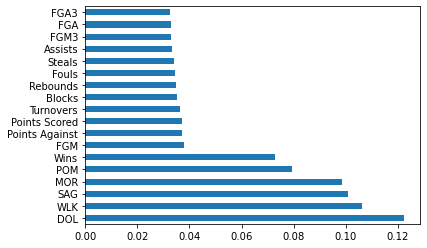

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = xTrain #independent columns
y = yTrain #target column
#apply SelectKBest class to extract top 10 best features
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=["Wins", "Points Scored", "Points Against", "Steals", "Rebounds", "Turnovers", "Assists", "Blocks", "Fouls", "FGA", "FGA3", "FGM", "FGM3", "POM", "MOR", "SAG", "WLK", "DOL"])
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('Feature Rankings', dpi=300, bbox_inches = "tight")
plt.show()

We now have our training data. `xTrain` contains 91,294 rows of data and 11 feature columns. `yTrain` contains the corresponding win/loss for the difference vector.

# Step 4: Testing Machine Learning Models

Now comes the fun part! Time to see which machine learning models best predict the data!

In [175]:
#Model Selection and Testing

#model = linear_model.LinearRegression()
#model = linear_model.Ridge(alpha=.5)
model = linear_model.Lasso(alpha=0.1)
#model = LogisticRegression(max_iter=400)
#model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
#model = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=1000, tol=1e-3))
#model = linear_model.BayesianRidge()
#model = ElasticNet(alpha=30)
#model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#model = make_pipeline(StandardScaler(), LinearSVC(tol=1e-4, max_iter=5000, penalty="l1", loss="squared_hinge", dual=False, C=10))
#model = make_pipeline(StandardScaler(), LinearSVR(tol=1e-4, max_iter=7000, C=10))
#model = tree.DecisionTreeClassifier()
#model = tree.DecisionTreeRegressor(criterion="poisson")
#model = KNeighborsRegressor(n_neighbors=50, algorithm="kd_tree")
#model = KNeighborsClassifier(n_neighbors=65, algorithm="kd_tree")
#model = NearestCentroid()
#model = GaussianNB()
#model = ComplementNB()
#model = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, tol=0.0001, C=0.1))
#model = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1)
#model = GradientBoostingRegressor()

In [474]:
accuracy = []

test_size = 0.30
lasso_accuracy = []
lasso_alpha = []
for i in range(1000):
    lalpha = (i + 1) / 100
    model = linear_model.Lasso(alpha=lalpha)
    for i in range(100):
        # Split into test and training sets
        X_train, X_test, Y_train, Y_test =  train_test_split(xTrain, yTrain, test_size=test_size)

        trained_model = model.fit(X_train, Y_train)
        predictions = model.predict(X_test)

        predictions[predictions < .5] = 0
        predictions[predictions >= .5] = 1

        accuracy.append(np.mean(predictions == Y_test))
        #print("Finished iteration:", i + 1, " with accuracy: ", np.mean(predictions == Y_test))
    lasso_accuracy.append(sum(accuracy) / len(accuracy))
    lasso_alpha.append(lasso_alpha)
    print("Accuracy for alpha", lalpha, ":", sum(accuracy)/len(accuracy))
zipAlpha = list(zip(lasso_alpha, lasso_accuracy))
optimize_lasso_alpha = pd.DataFrame(zipAlpha, columns = ["Alpha", "Accuracy"])

Accuracy for alpha 0.01 : 0.7616495673445541
Accuracy for alpha 0.02 : 0.7617083500675444
Accuracy for alpha 0.03 : 0.7615666873562378
Accuracy for alpha 0.04 : 0.7616555916608854
Accuracy for alpha 0.05 : 0.7617535506955342
Accuracy for alpha 0.06 : 0.7617721226283058
Accuracy for alpha 0.07 : 0.7617960808040771
Accuracy for alpha 0.08 : 0.7618954689838985
Accuracy for alpha 0.09 : 0.7619246575064608
Accuracy for alpha 0.1 : 0.761988352988426
Accuracy for alpha 0.11 : 0.7620162706328687
Accuracy for alpha 0.12 : 0.7620439470833792
Accuracy for alpha 0.13 : 0.7620819419362631
Accuracy for alpha 0.14 : 0.7620842308956143
Accuracy for alpha 0.15 : 0.7620788394367558
Accuracy for alpha 0.16 : 0.7620971010259584
Accuracy for alpha 0.17 : 0.7621137081653642
Accuracy for alpha 0.18 : 0.7620984093370812
Accuracy for alpha 0.19 : 0.7621095676135826
Accuracy for alpha 0.2 : 0.7621225674540872
Accuracy for alpha 0.21 : 0.7621309562928459
Accuracy for alpha 0.22 : 0.7621248410941355
Accuracy for 

Accuracy for alpha 1.85 : 0.7622017262799288
Accuracy for alpha 1.86 : 0.7622002652348026
Accuracy for alpha 1.87 : 0.7621978201561416
Accuracy for alpha 1.88 : 0.7621991415252084
Accuracy for alpha 1.89 : 0.7621995699428203
Accuracy for alpha 1.9 : 0.762200737522359
Accuracy for alpha 1.91 : 0.7622021413801772
Accuracy for alpha 1.92 : 0.7622018495868133
Accuracy for alpha 1.93 : 0.7622015097396384
Accuracy for alpha 1.94 : 0.7622010134251311
Accuracy for alpha 1.95 : 0.7622019283429304
Accuracy for alpha 1.96 : 0.7622024501866869
Accuracy for alpha 1.97 : 0.7622030260397588
Accuracy for alpha 1.98 : 0.7622034448689281
Accuracy for alpha 1.99 : 0.7622024687679491
Accuracy for alpha 2.0 : 0.7622030048559616
Accuracy for alpha 2.01 : 0.7622055918516127
Accuracy for alpha 2.02 : 0.7622063819073107
Accuracy for alpha 2.03 : 0.762204567041492
Accuracy for alpha 2.04 : 0.7622074000654309
Accuracy for alpha 2.05 : 0.7622055266980045
Accuracy for alpha 2.06 : 0.7622065888544982
Accuracy for a

Accuracy for alpha 3.68 : 0.7622125750261598
Accuracy for alpha 3.69 : 0.7622124315332088
Accuracy for alpha 3.7 : 0.7622131453444091
Accuracy for alpha 3.71 : 0.7622142095922848
Accuracy for alpha 3.72 : 0.7622137694004056
Accuracy for alpha 3.73 : 0.7622141224775044
Accuracy for alpha 3.74 : 0.7622143740910138
Accuracy for alpha 3.75 : 0.7622135757664329
Accuracy for alpha 3.76 : 0.7622139284834862
Accuracy for alpha 3.77 : 0.7622148575010281
Accuracy for alpha 3.78 : 0.7622152745057986
Accuracy for alpha 3.79 : 0.7622151912574793
Accuracy for alpha 3.8 : 0.7622155907769415
Accuracy for alpha 3.81 : 0.76221633510168
Accuracy for alpha 3.82 : 0.7622176384871202
Accuracy for alpha 3.83 : 0.7622185756760294
Accuracy for alpha 3.84 : 0.76221861612631
Accuracy for alpha 3.85 : 0.7622188137905459
Accuracy for alpha 3.86 : 0.7622183757444382
Accuracy for alpha 3.87 : 0.7622181701607385
Accuracy for alpha 3.88 : 0.7622183599179954
Accuracy for alpha 3.89 : 0.762218462349695
Accuracy for alph

Accuracy for alpha 5.51 : 0.7622564684286661
Accuracy for alpha 5.52 : 0.7622563174626728
Accuracy for alpha 5.53 : 0.7622564317969952
Accuracy for alpha 5.54 : 0.7622563058267358
Accuracy for alpha 5.55 : 0.7622566184425199
Accuracy for alpha 5.56 : 0.7622573889480786
Accuracy for alpha 5.57 : 0.7622577725676085
Accuracy for alpha 5.58 : 0.7622586880822582
Accuracy for alpha 5.59 : 0.7622589034117816
Accuracy for alpha 5.6 : 0.7622592418489056
Accuracy for alpha 5.61 : 0.7622595035843466
Accuracy for alpha 5.62 : 0.762259371342796
Accuracy for alpha 5.63 : 0.7622595709586772
Accuracy for alpha 5.64 : 0.7622596125586344
Accuracy for alpha 5.65 : 0.7622599952115526
Accuracy for alpha 5.66 : 0.7622606771153385
Accuracy for alpha 5.67 : 0.762262044334395
Accuracy for alpha 5.68 : 0.7622620986424451
Accuracy for alpha 5.69 : 0.7622627873709761
Accuracy for alpha 5.7 : 0.7622631713461469
Accuracy for alpha 5.71 : 0.7622638602596341
Accuracy for alpha 5.72 : 0.7622642384633375
Accuracy for a

KeyboardInterrupt: 

### MODEL ACCURACY:

#### LINEAR MODELS:
- Linear Regression: 76.10%
- Ridge Regression (alpha=0.5): 76.08%
- Lasso (alpha=0.1): 76.22%
- Logistic Regression: 76.19%
- Stochastic Gradient Descent (hinge): 75.75%
- Stochastic Gradient Descent (log): 75.90%
- Bayesian Ridge: 76.10%
- Elastic Net (alpha=30): 76.31%

#### TREES:
- Decision Tree Classifier: 66.13%
- Decision Tree Regressor (Squared Error): 66.08%
- Decision Tree Regressor (Poisson): 68.46 (only 1 iteration)

#### NEAREST NEIGHBORS:
- KNeighbors Regressor (n=2): 67.04%
- KNeighbors Regressor (n=50, kd_tree): 75.93%
- KNeighbors Classifier (n=65, kd_tree): 75.96%
- Nearest Centroid: 75.92%

#### NAIVE BAYES:
- Gaussian Naive Bayes: 75.70%

#### SVC and SVR:
- Linear SVC (tol=1e-5): 76.12%
- Linear SVC (tol=0.0001, C=0.1): 76.14%
- SVM SVC: 76.28% (only 1 iteration)
- SVM LinearSVC (penalty=l1, C=10, dual=False): 76.15%
- Linear SVR (): Too long didn't want to wait

#### Gradient Boosting Regressor:
- Gradient Boosting Regressor(): 76.27%

After testing out a variety of models, it seems there is not very much more possible predictive gain from model selection and algorithm tuning. In order to increase accuracy, other methods will most likely need to be applied. This includes going back and adjusting feature selection, feature engineering, atttempting ensemble methods, etc.

# Step 5: Finding Predictions

In [78]:
def predictGame(team1ID, team2ID, year):
    difVector = getDifferenceVector(team1ID, team2ID, year)
    return model.predict([difVector])[0]

#Chances of Gaonzaga beating Iowa in 2019
print(predictGame(1211, 1234, 2019))

0.550558576299452


The following will yield predictions for the matchup of any two teams for a given year

In [469]:
year = 2021
team1 = getTeamID("UCLA")
team2 = getTeamID("Michigan")

print("Probability that", getTeamName(team1), "beats", getTeamName(team2), ": ", predictGame(team1, team2, year))

Probability that UCLA beats Michigan :  0.41068533496639453


# Step 6: Going Further - Analysis of Predictions and Added Tuning

So far, the model is performing with respectable accuracy. With predictions averaging ~76%, this is most likely as high as it will get before the start of March Madness. There is potential for higher accuracy, but most would require more time than is available for me before the tournement. 

One problem, however, is that I believe the model is too predictable. March Madness is known for its unpredictability. I don't think there are many scenarios within a machine learning model that would ever give a 16 seed a higher chance to win than against a 1 seed. Even with this said, it HAS happened in March Madness before. Along the same lines, even though in almost every case, a 2 seed would be considered an almost assured win against a 15 seed, but historically, a 15 seed upsets a 2 seed around 6.3% of the time. The percentage chance of upsets only goes up from there. This is where I see a problem with my model. When testing it against historical data, it will get most of the "expected" games correctly, but the better team doesn't always win. There are a multitude of factors that are almost completely hidden going into a game, such as how certain players are feeling on game day, or just strokes of luck throughout a game for a certain team. Sometimes shots just seem to make the basket more often than usual on some days. Some players just happen to play better during the playoffs a particular year. Then there are also noticeably unpredictable factors, such as player injuries, sickness, or referee decisions. These are the types of factors that can lead to results going against a model which doesn't include these factors.

Although I will create a bracket that uses the direct predictions from the model, I already assume it will miss a large amount of upsets, as it appears to be giving too much bias towards generally stronger teams. In order to try to combat this, I want to add an element of randomness into the model predictions. I want to craft it in a way that pays attention to historical data on how often upsets occur. My first idea was to use a random number generator to generate a random number from 0-1 for each game played. Then, I would compare this number to the percent chance team 1 wins the game. If the generated number is less than the predicted number, then the prediction would output that team 1 will win the game. I may still use this idea, but I wanted to take it a little further to protect against too unpredictable of a model and keep in mind historical data. My idea for this was to instead not make the generated numbers completely random, but to make them follow a normal distribution, tuned to the average historical predictions of seeding with the models predictions based on seed. By first starting with a normal distribution of mean 0.5, I can then adjust the standard deviation to create a pseudo-randomness that models historical upset data with my models predictions. For example, if the 15 seed upsets the 2 seed ~6.3% of the time, then my model should roughly output a win from the 15 seed, even if it sees the 2 seed as a better team 6-7% of the time. 

I am not sure on my thoughts for this method yet. It is essentially telling my model to not trust its predictions a certain number of times, but I think that it is needed to produce a bracket with enough upsets, because it is not a strong enough model to predict the essentially unpredictable elements of March Madness. 

In [162]:
#the perfect table to getting all the tournament seeds
tourney_seed_raw = pd.read_csv("MNCAATourneySeeds.csv")
print(tourney_seed_raw.head())

#we only want the years we have data/predictions for
tourney_seed_copy = tourney_seed_raw[tourney_seed_raw["Season"] > 2002]
print(tourney_seed_copy.head())

#didn't like the false error that was showing from the following lines
pd.options.mode.chained_assignment = None  # default='warn'

#remove that pesky letter on the seed. we dont need it
tourney_seed = tourney_seed_copy
tourney_seed["Seed"] = tourney_seed_copy["Seed"].str[1:]
tourney_seed.head()

   Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374
      Season Seed  TeamID
1154    2003  W01    1328
1155    2003  W02    1448
1156    2003  W03    1393
1157    2003  W04    1257
1158    2003  W05    1280


,Season,Seed,TeamID
1154,2003,01,1328
1155,2003,02,1448
1156,2003,03,1393
1157,2003,04,1257
1158,2003,05,1280


Now we want to combine this seed data with prediction results for all the past March Madness tournaments since 2003. Let's take a quick look at the tournament dataset again...

In [117]:
playoff_games_raw = pd.read_csv("MNCAATourneyCompactResults.csv")
print(playoff_games_raw.head())

#only for >= 2003 seasons
playoff_games = playoff_games_raw[playoff_games_raw["Season"] > 2002]
playoff_games.head()

   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1136,2003,134,1421,92,1411,84,N,1
1137,2003,136,1112,80,1436,51,N,0
1138,2003,136,1113,84,1272,71,N,0
1139,2003,136,1141,79,1166,73,N,0
1140,2003,136,1143,76,1301,74,N,1


Now time to set up some functions to produce all the percentage wins per seed. I want to start with only first round games, as those are the number I want to compare.

In [121]:
def getSeed(teamID, year):
    seed_line = tourney_seed[(tourney_seed["TeamID"] == teamID) & (tourney_seed["Season"] == year)]
    seed = seed_line.iloc[0][1]
    return seed

#test getting the seed of Gonzaga in 2021
print("Gonzaga Seed in 2021:", getSeed(getTeamID("Gonzaga"), 2021))

Gonzaga Seed in 2021: 01


In [135]:
def getSeedResults():
    game_results = []
    counter = 0
    for year in range(2003, 2022): 
        for index, row in playoff_games.iterrows():
            try:
                team1 = row[2]
                team2 = row[4]
            except:
                continue
            try:
                seed1 = getSeed(team1, year)
                seed2 = getSeed(team2, year)
            except:
                continue
                
            if (seed1 == "01" and seed2 == "16") or (seed1 == "02" and seed2 == "15") or (seed1 == "03" and seed2 == "14") or (seed1 == "04" and seed2 == "13") or (seed1 == "05" and seed2 == "12") or (seed1 == "06" and seed2 == "11") or (seed1 == "07" and seed2 == "10") or (seed1 == "08" and seed2 == "09") or (seed1 == "09" and seed2 == "08") or (seed1 == "10" and seed2 == "07") or (seed1 == "11" and seed2 == "06") or (seed1 == "12" and seed2 == "05") or (seed1 == "13" and seed2 == "04") or (seed1 == "14" and seed2 == "03") or (seed1 == "15" and seed2 == "02") or (seed1 == "16" and seed2 == "01"):
                prediction = predictGame(team1, team2, year)
                game_results.append([seed1, seed2, prediction])
    seedPercent = pd.DataFrame(game_results, columns = ["Seed1", "Seed2", "Prediction"])
    print(counter)
    return seedPercent

seedResults = getSeedResults()
seedResults.head()

22439


,Seed1,Seed2,Prediction
0,01,16,0.893373
1,10,07,0.440238
2,11,06,0.455124
3,08,09,0.556278
4,05,12,0.523252


In [140]:
seedResults["Seed1"].value_counts()

02    87
03    73
04    70
05    65
07    65
09    63
08    58
01    48
10    47
06    43
11    35
12    35
13    19
14    11
15     5
16     3
Name: Seed1, dtype: int64

In [314]:
tester = seedResults[seedResults["Seed1"] == "02"]
tester.min()

Seed1               02
Seed2               15
Prediction    0.668323
dtype: object

In [212]:
one_seed = seedResults[(seedResults["Seed1"] == "01") | (seedResults["Seed2"] == "01")]
one_percent = one_seed["Prediction"].mean()

two_seed = seedResults[(seedResults["Seed1"] == "02") | (seedResults["Seed2"] == "02")]
two_percent = two_seed["Prediction"].mean()

three_seed = seedResults[(seedResults["Seed1"] == "03") | (seedResults["Seed2"] == "03")]
three_percent = three_seed["Prediction"].mean()

four_seed = seedResults[(seedResults["Seed1"] == "04") | (seedResults["Seed2"] == "04")]
four_percent = four_seed["Prediction"].mean()

five_seed = seedResults[(seedResults["Seed1"] == "05") | (seedResults["Seed2"] == "05")]
five_percent = five_seed["Prediction"].mean()

six_seed = seedResults[(seedResults["Seed1"] == "06") | (seedResults["Seed2"] == "06")]
six_percent = six_seed["Prediction"].mean()

seven_seed = seedResults[(seedResults["Seed1"] == "07") | (seedResults["Seed2"] == "07")]
seven_percent = seven_seed["Prediction"].mean()

eight_seed = seedResults[(seedResults["Seed1"] == "08") | (seedResults["Seed2"] == "08")]
eight_percent = eight_seed["Prediction"].mean()

print("Seed 1:", one_percent)
print("Seed 2:", two_percent)
print("Seed 3:", three_percent)
print("Seed 4:", four_percent)
print("Seed 5:", five_percent)
print("Seed 6:", six_percent)
print("Seed 7:", seven_percent)
print("Seed 8:", eight_percent)


Seed 1: 0.8738455862825074
Seed 2: 0.7754256550458961
Seed 3: 0.636869514764854
Seed 4: 0.5953706538404887
Seed 5: 0.5310074153278291
Seed 6: 0.5084366488921516
Seed 7: 0.5098632825621627
Seed 8: 0.5010995353600394


Looking at the above results, a trend can be found for predictions of the model compared to historical seeding results. One seeds win more often in the first round, followed by 2 seed, all the way to seed 8. The model results follow essentially the same pattern, with only seed 6 performing slightly lower than seed 7, but within a margin of error considering the dataset is not very large. Using this information, I was able to roughly find a distribution that fits these predictions with historical results of seeding. Using information I received from https://www.ncaa.com/news/basketball-men/bracketiq/2018-03-13/heres-how-pick-march-madness-upsets-according-data

- No. 16 seed over No. 1 seed	1	0.7%
- No. 15 seed over No. 2 seed	9	6.3%
- No. 13 seed over No. 4 seed	31	21.5%
- No. 14 seed over No. 3 seed	22	15.3%
- No. 12 seed over No. 5 seed	51	35.4%
- No. 11 seed over No. 6 seed	54	37.5%
- No. 10 seed over No. 7 seed	57	39.5%

One thing to note: a number 9 seed beating a number 8 seed is not considered an upset. Historically, number 9 seeds actually have a slightly better record than number 8 seeds, but it is essentially a toss up in most cases.

My first thought was to randomly select a number from a normal distribution with a mean of 0.5 and SD of 0.13.

The difference between randomy generating numbers on a normal distribution versus uniformly from 0 to 1 is that it still provides the "random" aspect, but gives more emphasis on the models predictions.

For example: If the model predictions a score of 0.55 for team 1 to beat team 2, the uniform distribution approach would give team 1 a 55% chance to win. However, with the normal distribution approach, team 1 would have ~65% chance to win (mean=0.5, SD=0.13). 

These parameters also yield, on average based on the previous seeding predictions, about a 1.72% for a 15 seed to upset a 2 seed. This does not mean every 15 v 2 seed game has the same upset probability. Based on the historical data, the highest this method would give is a ~10% chance for an upset. 

I plan to experiment with the paramters a little more to try to determine the best standard deviation to allow for upsets without too much deviation.

In [323]:
testing = np.random.normal(0.5, 0.13)
print(testing)

0.4398234615638634


In [451]:
#predict games with normal distribution
def predictGameGaussian(team1ID, team2ID, year, sd):
    difVector = getDifferenceVector(team1ID, team2ID, year)
    prediction =  predictGame(team1ID, team2ID, year)
    gaussianRandom = np.random.normal(0.5, sd)
    if gaussianRandom <= prediction:
        return 1, prediction, gaussianRandom
    else:
        return 0, prediction, gaussianRandom



In [367]:
team1 = getTeamID("UCLA")
team2 = getTeamID("Michigan")
year = 2021

result, prediction, gaussianRandom = predictGameGaussian(team1, team2, year, 0.13)
print(result, prediction, gaussianRandom)

0 0.41068533496639453 0.4758021021652718


In [487]:
playoffs = pd.read_csv("MNCAATourneyDetailedResults.csv")
playoffs_2021 = playoffs[playoffs["Season"] == 2021]
playoffs_2017 = playoffs[playoffs["Season"] == 2017]
playoffs_2019 = playoffs[playoffs["Season"] == 2019]
playoffs_2018 = playoffs[playoffs["Season"] == 2018]
playoffs2021 = playoffs_2021[["WTeamID", "LTeamID", "Season"]]
playoffs2017 = playoffs_2017[["WTeamID", "LTeamID", "Season"]]
playoffs2019 = playoffs_2019[["WTeamID", "LTeamID", "Season"]]
playoffs2018 = playoffs_2018[["WTeamID", "LTeamID", "Season"]]
playoffs2021.head()

,WTeamID,LTeamID,Season
1115,1179,1455,2021
1116,1313,1111,2021
1117,1411,1291,2021
1118,1417,1277,2021
1119,1116,1159,2021


In [449]:
#predicting an entire round
#schedule dataframe in format of [team1, team2, year]
def predictRoundGaus(schedule, sd):
    team1s = []
    team2s = []
    team1ids = []
    team2ids = []
    results = []
    predictions = []
    gaussianRandoms = []
    for index, row in schedule.iterrows():
        switchWinner = random()
        winteam = row[0]
        loseteam = row[1]
        if switchWinner >= 0.5:
            team1 = row[0]
            team2 = row[1]
        else:
            team2 = row[0]
            team1 = row[1]
        year = row[2]
        result, prediction, gaussianRandom = predictGameGaussian(team1, team2, year, sd)
        results.append(result)
        predictions.append(prediction)
        gaussianRandoms.append(gaussianRandom)
        team1s.append(getTeamName(team1))
        team2s.append(getTeamName(team2))
        team1ids.append(winteam)
        team2ids.append(loseteam)
        zipSchedule = list(zip(team1s, team2s, results, predictions, gaussianRandoms, team1ids, team2ids))
    scheduleResults = pd.DataFrame(zipSchedule, columns = ["Team 1", "Team 2", "Result", "Prediction", "Random Gaussian", "WinID", "LoseID"])
    return scheduleResults

In [417]:
mm2021Predict = predictRoundGaus(playoffs2021, 0.13)
pd.set_option('display.max_rows', mm2021Predict.shape[0]+1)
mm2021Predict.head(66)

,Team 1,Team 2,Result,Prediction,Random Gaussian,WinID,LoseID
0,Wichita St,Drake,0,0.503642,0.504177,1179,1455
1,Norfolk St,Appalachian St,0,0.483690,0.490466,1313,1111
2,TX Southern,Mt St Mary's,0,0.502810,0.503684,1411,1291
3,UCLA,Michigan St,0,0.503149,0.504641,1417,1277
4,Colgate,Arkansas,0,0.479443,0.493461,1116,1159
5,Hartford,Baylor,0,0.099808,0.495359,1124,1216
6,Virginia Tech,Florida,0,0.488294,0.489125,1196,1439
7,Houston,Cleveland St,1,0.795195,0.520187,1222,1156
8,Illinois,Drexel,1,0.889767,0.486438,1228,1180
9,Georgia Tech,Loyola-Chicago,0,0.487443,0.500328,1260,1210


In [399]:
def findAccuracy(schedule):
    accuracyIndex = []
    for index, row in schedule.iterrows():
        if row["Result"] == 1:
            team1ID = getTeamID(row["Team 1"])
            if team1ID == row["WinID"]:
                accuracyIndex.append(1)
            else:
                accuracyIndex.append(0)
        else:
            team2ID = getTeamID(row["Team 2"])
            if team2ID == row["WinID"]:
                accuracyIndex.append(1)
            else:
                accuracyIndex.append(0)
    return accuracyIndex

def calcAccuracy(accuracyIndex):
    counter = 0
    for index in accuracyIndex:
        if index == 1:
            counter += 1
    accuracy = counter / len(accuracyIndex)
    return accuracy

In [494]:
totalAccuracy = []
allSDAccuracy = []
allSD = []
allAccuracy = []
highAcc = []
lowAcc = []
for i in range(200):
    sd = (i + 1) / 1000
    for i in range(20):
        mm2019Predict = predictRoundGaus(playoffs2019, sd)
        accuracyIndex = findAccuracy(mm2019Predict)
        modelAccuracy = calcAccuracy(accuracyIndex)
        totalAccuracy.append(modelAccuracy)
        #print("Round", i+1, " Accuracy:", modelAccuracy)
    allAccuracy.append(np.mean(totalAccuracy))
    allSD.append(sd)
    highAcc.append(max(totalAccuracy))
    lowAcc.append(min(totalAccuracy))
    print("Total Average Accuracy for SD", sd, "=", np.mean(totalAccuracy))
    print("Highest Accuracy for SD", sd, "=", max(totalAccuracy))
    print("Lowest Accuracy for SD", sd, "=", min(totalAccuracy))
zipAcc = list(zip(allSD, allAccuracy, highAcc, lowAcc))
sdAccuracy2019 = pd.DataFrame(zipAcc, columns = ["SD", "Mean Accuracy", "Highest Accuracy", "Lowest Accuracy"])

Total Average Accuracy for SD 0.001 = 0.7238805970149255
Highest Accuracy for SD 0.001 = 0.7313432835820896
Lowest Accuracy for SD 0.001 = 0.7014925373134329
Total Average Accuracy for SD 0.002 = 0.7220149253731344
Highest Accuracy for SD 0.002 = 0.7313432835820896
Lowest Accuracy for SD 0.002 = 0.6865671641791045
Total Average Accuracy for SD 0.003 = 0.718905472636816
Highest Accuracy for SD 0.003 = 0.7313432835820896
Lowest Accuracy for SD 0.003 = 0.6865671641791045
Total Average Accuracy for SD 0.004 = 0.7151119402985074
Highest Accuracy for SD 0.004 = 0.7313432835820896
Lowest Accuracy for SD 0.004 = 0.6567164179104478
Total Average Accuracy for SD 0.005 = 0.7129850746268656
Highest Accuracy for SD 0.005 = 0.7313432835820896
Lowest Accuracy for SD 0.005 = 0.6567164179104478
Total Average Accuracy for SD 0.006 = 0.7129353233830845
Highest Accuracy for SD 0.006 = 0.7611940298507462
Lowest Accuracy for SD 0.006 = 0.6567164179104478
Total Average Accuracy for SD 0.007 = 0.7127931769722

Total Average Accuracy for SD 0.054 = 0.7010364842454395
Highest Accuracy for SD 0.054 = 0.8059701492537313
Lowest Accuracy for SD 0.054 = 0.5522388059701493
Total Average Accuracy for SD 0.055 = 0.7006105834464044
Highest Accuracy for SD 0.055 = 0.8059701492537313
Lowest Accuracy for SD 0.055 = 0.5522388059701493
Total Average Accuracy for SD 0.056 = 0.7001465884861408
Highest Accuracy for SD 0.056 = 0.8059701492537313
Lowest Accuracy for SD 0.056 = 0.5522388059701493
Total Average Accuracy for SD 0.057 = 0.6996334118879288
Highest Accuracy for SD 0.057 = 0.8059701492537313
Lowest Accuracy for SD 0.057 = 0.5522388059701493
Total Average Accuracy for SD 0.058 = 0.6993823983530623
Highest Accuracy for SD 0.058 = 0.8059701492537313
Lowest Accuracy for SD 0.058 = 0.5522388059701493
Total Average Accuracy for SD 0.059 = 0.6992916772071844
Highest Accuracy for SD 0.059 = 0.8059701492537313
Lowest Accuracy for SD 0.059 = 0.5522388059701493
Total Average Accuracy for SD 0.06 = 0.6991044776119

Total Average Accuracy for SD 0.107 = 0.6846980053005998
Highest Accuracy for SD 0.107 = 0.8208955223880597
Lowest Accuracy for SD 0.107 = 0.5223880597014925
Total Average Accuracy for SD 0.108 = 0.6842730790491984
Highest Accuracy for SD 0.108 = 0.8208955223880597
Lowest Accuracy for SD 0.108 = 0.5223880597014925
Total Average Accuracy for SD 0.109 = 0.6839038751198138
Highest Accuracy for SD 0.109 = 0.8208955223880597
Lowest Accuracy for SD 0.109 = 0.5223880597014925
Total Average Accuracy for SD 0.11 = 0.6835278154681139
Highest Accuracy for SD 0.11 = 0.8208955223880597
Lowest Accuracy for SD 0.11 = 0.5223880597014925
Total Average Accuracy for SD 0.111 = 0.6832123167944064
Highest Accuracy for SD 0.111 = 0.8208955223880597
Lowest Accuracy for SD 0.111 = 0.5223880597014925
Total Average Accuracy for SD 0.112 = 0.682862473347548
Highest Accuracy for SD 0.112 = 0.8208955223880597
Lowest Accuracy for SD 0.112 = 0.5223880597014925
Total Average Accuracy for SD 0.113 = 0.6825386342623168

Total Average Accuracy for SD 0.16 = 0.6681576492537314
Highest Accuracy for SD 0.16 = 0.8208955223880597
Lowest Accuracy for SD 0.16 = 0.417910447761194
Total Average Accuracy for SD 0.161 = 0.6678826365069065
Highest Accuracy for SD 0.161 = 0.8208955223880597
Lowest Accuracy for SD 0.161 = 0.417910447761194
Total Average Accuracy for SD 0.162 = 0.6676386585590566
Highest Accuracy for SD 0.162 = 0.8208955223880597
Lowest Accuracy for SD 0.162 = 0.417910447761194
Total Average Accuracy for SD 0.163 = 0.6674617709001008
Highest Accuracy for SD 0.163 = 0.8208955223880597
Lowest Accuracy for SD 0.163 = 0.417910447761194
Total Average Accuracy for SD 0.164 = 0.6671641791044777
Highest Accuracy for SD 0.164 = 0.8208955223880597
Lowest Accuracy for SD 0.164 = 0.417910447761194
Total Average Accuracy for SD 0.165 = 0.6668837630031661
Highest Accuracy for SD 0.165 = 0.8208955223880597
Lowest Accuracy for SD 0.165 = 0.417910447761194
Total Average Accuracy for SD 0.166 = 0.6666202121920519
High

In [498]:
print(sdAccuracy2021.head())
sdAccuracy2021.to_csv("sdAccuracy2021.csv")

      SD  Mean Accuracy  Highest Accuracy  Lowest Accuracy
0  0.001       0.653788          0.666667         0.636364
1  0.002       0.654167          0.681818         0.636364
2  0.003       0.656818          0.681818         0.621212
3  0.004       0.657386          0.696970         0.621212
4  0.005       0.656667          0.696970         0.621212


In [499]:
print(sdAccuracy2018.head())
sdAccuracy2018.to_csv("sdAccuracy2018.csv")

      SD  Mean Accuracy  Highest Accuracy  Lowest Accuracy
0  0.001       0.727612          0.731343         0.716418
1  0.002       0.725746          0.746269         0.701493
2  0.003       0.727612          0.746269         0.701493
3  0.004       0.727052          0.746269         0.701493
4  0.005       0.726119          0.746269         0.701493


In [500]:
print(sdAccuracy2019.head())
sdAccuracy2019.to_csv("sdAccuracy2019.csv")

      SD  Mean Accuracy  Highest Accuracy  Lowest Accuracy
0  0.001       0.723881          0.731343         0.701493
1  0.002       0.722015          0.731343         0.686567
2  0.003       0.718905          0.731343         0.686567
3  0.004       0.715112          0.731343         0.656716
4  0.005       0.712985          0.731343         0.656716


Text(0, 0.5, 'Accuracy')

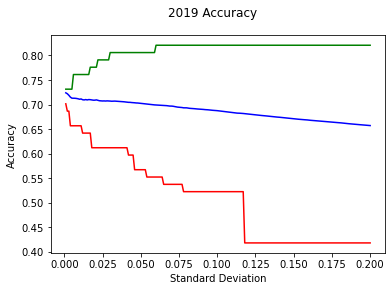

In [568]:
fig, ax = plt.subplots(1)
ax = sns.lineplot(x='SD', y='Mean Accuracy', color='blue', data=sdAccuracy2019)
ax1 = sns.lineplot(x='SD', y='Highest Accuracy', color='green', data=sdAccuracy2019)
ax2 = sns.lineplot(x='SD', y='Lowest Accuracy', color='red', data=sdAccuracy2019)
fig.suptitle('2019 Accuracy')
plt.xlabel('Standard Deviation')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

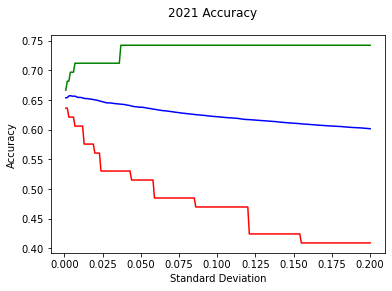

In [558]:
fig, ax = plt.subplots()
ax= sns.lineplot(x='SD', y='Mean Accuracy', color='blue', data=sdAccuracy2021)
ax1 = sns.lineplot(x='SD', y='Highest Accuracy', color = 'green', data=sdAccuracy2021)
ax2 = sns.lineplot(x='SD', y='Lowest Accuracy', color='red', data=sdAccuracy2021)
fig.suptitle('2021 Accuracy')
plt.xlabel('Standard Deviation')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

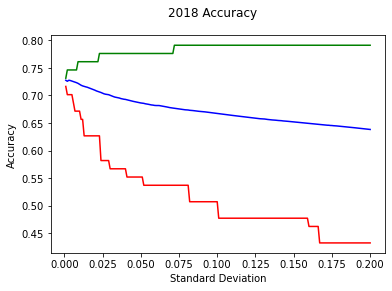

In [559]:
fig, ax = plt.subplots()
ax= sns.lineplot(x='SD', y='Mean Accuracy', color='blue', data=sdAccuracy2018)
ax1 = sns.lineplot(x='SD', y='Highest Accuracy', color='green', data=sdAccuracy2018)
ax2 = sns.lineplot(x='SD', y='Lowest Accuracy', color='red', data=sdAccuracy2018)
fig.suptitle('2018 Accuracy')
plt.xlabel('Standard Deviation')
plt.ylabel('Accuracy')